# Project Zillow

* Predict the tax assessed property value of Zillow Single Family Residential properties with transaction date in 2017

## Goal

* Discover drivers of property value
* Use drivers to develop a machine learning model to predict property value

## Imports

In [1]:
# local imports
import wrangle as w
import explore as e
import modeling as m

## Acquire

* Data acquired from Codeup MySQL DB
* Data initially acquired on 15 May 2023
* It contained 52,441 rows and 62 columns before cleaning
* Each row represents a unique parcel/property for each transaction it had in 2017
* Each column represents an element of the parcel/property

## Prepare

**Prepare Actions**:

* Replaced null values with appropriate values if logical
    - 0 for most columns
* Renamed columns to promote readability
* Removed columns that did not contain useful information
    - too many null values that couldn't be logically imputed
    - related to target (tax assessed property value)
    - duplicated information
* Removed rows
    - nulls that couldn't logically be imputed
    - duplicate parcels, kept most recent transaction date
* Checked that column data types were appropriate
* Handled outliers
    - property value < 98th quantile
    - area < 6000
* Mapped FIPS code to county
* Created custom features
* Encoded categorical variables
    - created dummy variables for categorical variables
* Split data into train, validate and test (approx. 60/20/20)
* Scaled using Standard Scaler for modeling

In [2]:
# acquire, clean, and prepare the data
df = w.wrangle_zillow()

# encode categorical
df = w.encode_county(df)

# split into train, validate, and test datasets
train, validate, test = w.split_data(df)

#### A brief look at the data

In [3]:
train.head()

,age,baths,beds,roomcnt,area,county,latitude,longitude,prop_value,Orange,LA,Ventura
9568,73,2.0,3,0.0,1001,LA,33800512.0,-118213302.0,265150,0,1,0
18363,3,2.0,3,6.0,1580,Orange,33634652.0,-117898149.0,1275356,1,0,0
2877,54,2.0,3,5.0,1128,Orange,33753941.0,-118032920.0,498221,1,0,0
30380,63,2.0,4,0.0,1188,LA,34213276.0,-118521205.0,105337,0,1,0
2657,75,2.0,3,0.0,1470,LA,33843316.0,-118173744.0,399808,0,1,0


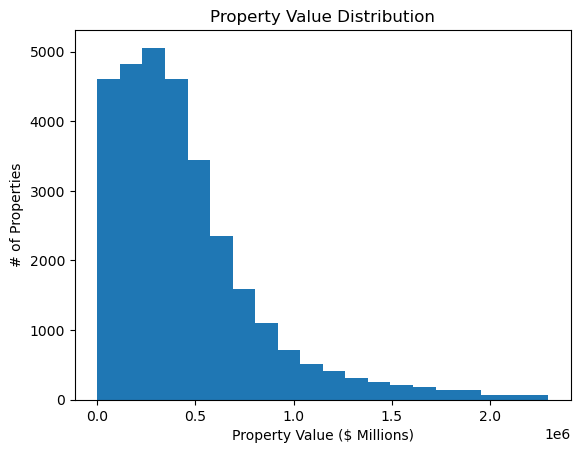

In [4]:
# target distribution
e.dist(train)

## Explore

* Is there a correlation between area and property value?
* Is there a correlation between age and property value?
* Is there a correlation between the room count and property value?
* Is there a difference in average property value between counties?

### 1) Is there a correlation between area and property value?
* $H_0$: There is **NO** correlation between area and property value
* $H_a$: There is a correlation between area and property value
* Continuous (area) vs Continuous (prop_value) = $Spearman's R$
    - $r$ = 0.5017813399669965
    - $p$ = 0.0
* `Area` is correlated with `property value`

Spearman's R: area and prop_value
 r = 0.5017813399669965, p = 0.0


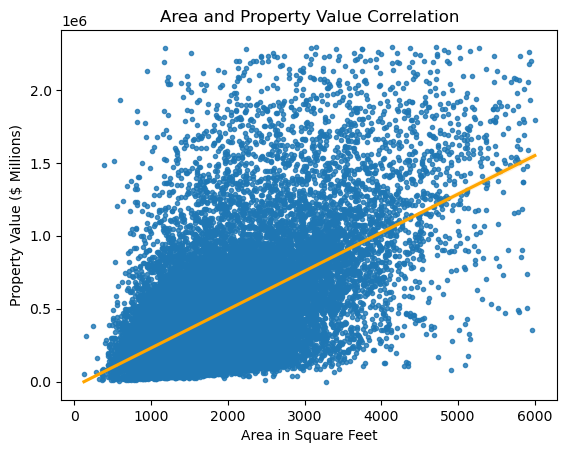

In [5]:
# explore area and property value
e.ap(train)

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that area and property value are correlated with each other. I believe that using `area` in the modeling will have a positive impact.**

### 2) Is there a correlation between age and property value?
* $H_0$: There is **NO** correlation between age and property value
* $H_a$: There is a correlation between age and property value
* Continuous (age) vs Continuous (prop_value) = $Spearman's R$
    - $r$ = -0.26796888401105634
    - $p$ = 0.0
* `Age` is negatively correlated with `property value`

Spearman's R: age and prop_value
 r = -0.26796888401105634, p = 0.0


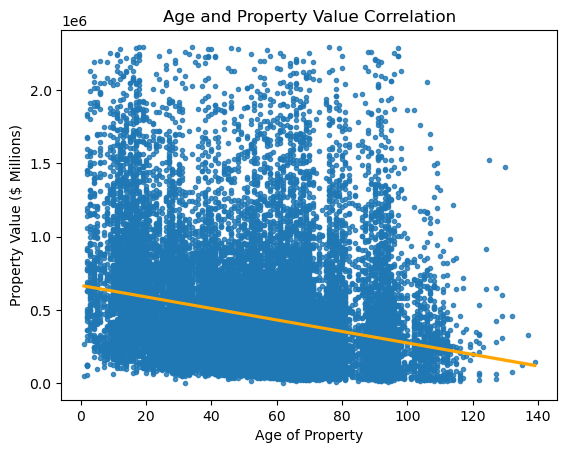

In [6]:
# explore age and property value
e.yp(train)

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that age and property value are negatively correlated with each other. I believe that using `age` in the modeling will have a positive impact.**

### 3) Is there a correlation between the room count and property value?
* $H_0$: There is **NO** correlation between room count and property value
* $H_a$: There is a correlation between room count and property value
* Continuous (roomcnt) vs Continuous (prop_value) = $Spearman's R$
    - $r$ = 0.07635447873979384
    - $p$ = 7.760619779932516e-41
* `Room count` is correlated with `property value`

Spearman's R: roomcnt and prop_value
 r = 0.07635447873979384, p = 7.760619779932516e-41


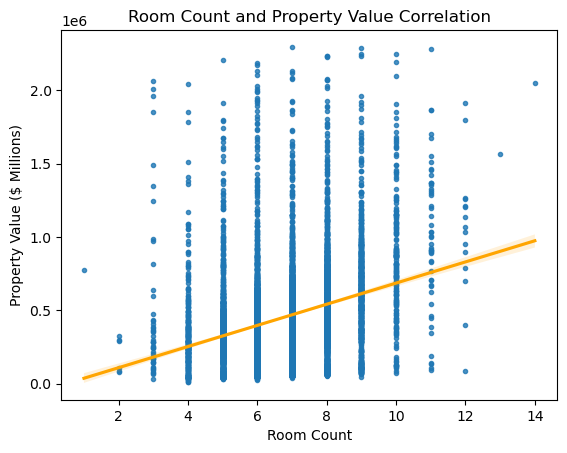

In [7]:
# explore room count and property value
e.cp(train)

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that room count and property value are correlated with each other. I believe that using `room count` in the modeling will have a positive impact.**

### 4) Is there a difference in average property value between counties?
* $H_0$: There is **NO** difference in property value
* $H_a$: There is a difference in property value
* Discrete (county) vs Continuous (prop_value) = $Kruskal$-$Wallis$ $H$
    - $H$ statistic = 1122.2740145413604
    - $p$ = 2.0012168486441073e-244
* There is a difference in `property value` based on `county`

Kruskal-Wallis H-Test:
 stat = 1122.2740145413604, p = 2.0012168486441073e-244


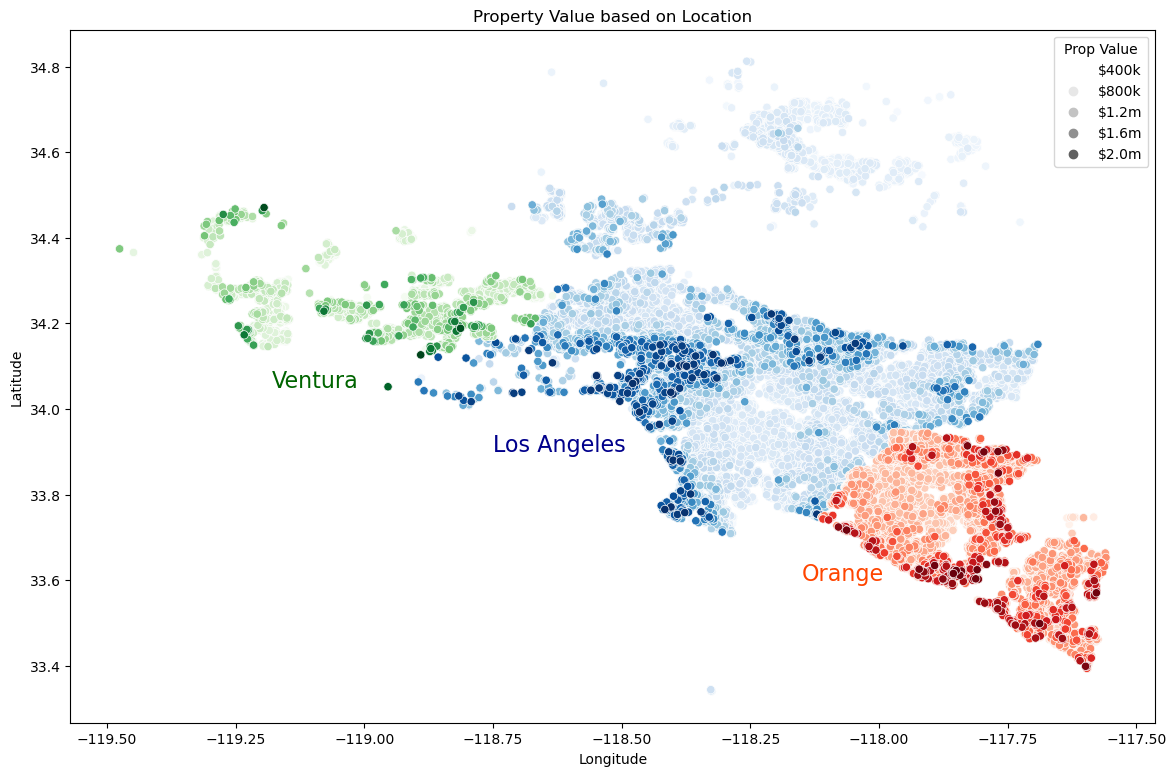

In [8]:
# explore average property value and counties
e.lp(train)

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that there is a difference in average property value among the three counties. I believe that using an encoded `county` in the modeling will have a positive impact.**

## Exploration Summary
* Area, age, and room count are all correlated with property value
* There is a difference in property value based on county

### Features for modeling
* Features that will be used:
    - property value (target)
* Some features that may be useful:
    - area
    - age
    - room count
    - county

## Modeling

* $RMSE$ and $R^2$ will be the evaluation metrics
* Target feature is property value
* Using the mean of the property values as the baseline
    - 454401.68 will be the baseline property value
* Features scaled using Standard Scaler
* Models will be developed and evaluated using a few different model types, various features, and various hyperparameter configurations
    - Linear Regression
    - Polynomial Features through Linear Regression
    - Lasso Lars
* Models will be evaluated on train and validate datasets
* Best performing model will be the only one evaluated on the test dataset

In [9]:
# split into X and y
X_train,X_val,X_test = train.drop(columns=['prop_value','county']),validate.drop(columns=['prop_value','county']),test.drop(columns=['prop_value','county'])
y_train,y_val,y_test = train[['prop_value']],validate[['prop_value']],test[['prop_value']]

# Standard Scaler
Xs_train,Xs_val,Xs_test = w.std_zillow(X_train,X_val,X_test)

In [10]:
# get baseline accuracy
m.baseline(y_train,y_val)

Baseline Property Value: 454401.68
Train       RMSE: 376239.8580678781   R2: 0.0
Validate    RMSE: 374507.60109540797    R2: -1.3876480933205926e-06


### Best of 3 Model Configurations

#### Linear Regression

In [11]:
# get linear regression results
m.final_model('lr',Xs_train,y_train,Xs_val,y_val)

Linear Regression
Train       RMSE: 287574.6   R2: 0.4158
Validate    RMSE: 290807.5    R2: 0.397


#### Polynomial Features through Linear Regression

In [12]:
# get polynomial feature results
m.final_model('poly',Xs_train,y_train,Xs_val,y_val)

Polynomial Features through Linear Regression
Train       RMSE: 266137.07   R2: 0.4996
Validate    RMSE: 274174.47    R2: 0.464


#### Lasso Lars

In [13]:
# get lasso lars results
m.final_model('lasso',Xs_train,y_train,Xs_val,y_val)

Lasso Lars
Train       RMSE: 287574.6   R2: 0.4158
Validate    RMSE: 290807.44    R2: 0.397


### Best on Test
* Polynomial Features

In [14]:
# get test results for final model
m.test_model(Xs_train,y_train,Xs_test,y_test)

Polynomial Features through Linear Regression
Test    RMSE: 270756.91    R2: 0.4851


#### How does it compare?

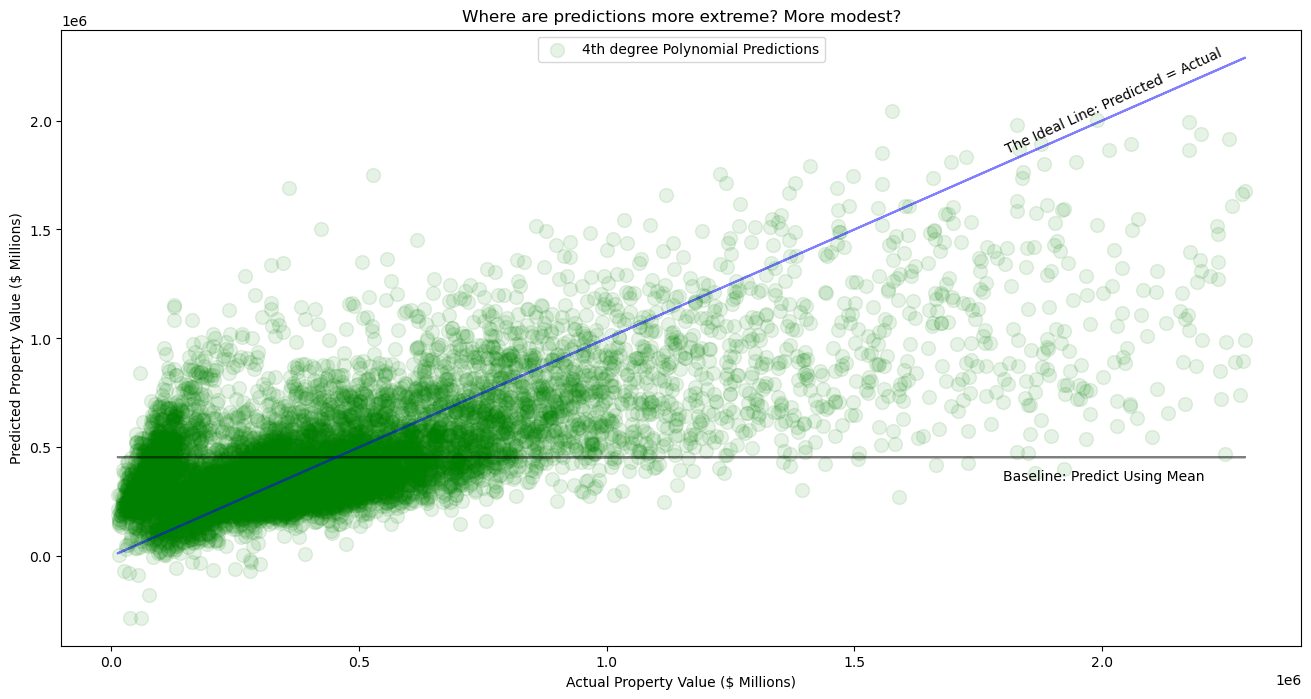

In [15]:
# plot predictions vs actual of test
m.plt_err(Xs_train,y_train,Xs_test,y_test)

### Modeling Wrap Up
* Linear Regression and Lasso Lars had similar RMSE and R2 for train and validate, RMSE about 287k/290k and R2 about 0.4158/0.397
* Polynomial Features had the best performance for train and validate, RMSE was the smallest 266k/274k and R2 was the largest 0.4996/0.464
* With the test done on Polynomial Features, we get RMSE 270k and R2 0.4851
* It's an okay model but if the predictions could be off by 270k then I think the model could be improved more

## Conclusion

### Takeaways and Key Findings
* The younger the property the better for property value
* The bigger the living area the bigger the property value
* Location matters for property value
* Model still needs improvement

### Recommendations and Next Steps
* It would nice to have the data to check if the included appliances or the type of heating services (gas or electric) of the property would affect property value
* More time is needed to work on features to better improve the model
    - latitude and longitude could hopefully give insights into cities and neighborhoods with higher or lower property values
    - pools and garages could also be looked into